In [ ]:
pip install lightkurve

In [3]:
import lightkurve as lk
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks

import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/drive/MyDrive/CS464_Project/baseline_df.csv')
df

,kepid,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,flux_9,...,flux_992,flux_993,flux_994,flux_995,flux_996,flux_997,flux_998,flux_999,flux_1000,label
0,10797460.0,0.999956,0.999976,0.999927,0.999900,0.999946,0.999974,0.999817,1.000073,0.999805,...,0.999985,1.000216,0.999849,0.999988,0.999935,0.999952,1.000010,1.000180,0.999846,1.0
1,10848459.0,1.000090,NaN,0.999933,1.000010,1.000484,1.000211,0.999942,1.000306,1.000175,...,1.000171,1.000071,1.000015,1.000282,1.000190,0.999994,1.000019,1.000038,1.000262,0.0
2,10797460.0,1.000086,1.000074,0.999959,1.000018,1.000172,0.999981,0.999912,1.000094,1.000037,...,1.000001,0.999999,0.999876,1.000060,0.999987,0.999778,0.999984,1.000067,0.999960,1.0
3,6721123.0,0.999984,1.000008,0.999981,0.999999,0.999918,0.999998,0.999958,0.999988,0.999988,...,1.000084,0.999993,1.000052,1.000010,0.999980,0.999998,1.000053,0.999989,0.999980,0.0
4,10811496.0,1.000903,1.001195,1.000961,1.000900,1.001421,1.001033,1.001075,1.000885,1.001231,...,1.000613,1.000885,1.000414,1.000970,1.000982,1.001035,1.000859,1.000877,1.001111,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,7385478.0,0.971661,0.971380,0.972461,0.972846,0.972024,0.973323,0.972122,0.971978,0.974114,...,0.972629,0.972105,0.973354,0.971585,0.971950,0.972582,0.971816,0.972936,0.971686,0.0
4196,10252275.0,1.000045,1.000115,1.000045,1.000020,1.000069,0.999995,1.000116,1.000040,0.999952,...,1.000082,1.000066,0.999964,1.000027,1.000101,1.000195,1.000072,1.000057,1.000073,1.0
4197,8243263.0,1.001005,1.001022,1.001116,1.001035,1.000948,1.000980,1.001039,1.001080,1.001096,...,1.001043,1.000983,1.000996,1.001108,1.001121,1.000972,1.001069,1.001014,1.001113,0.0
4198,11455181.0,1.000072,1.000068,0.999932,0.999975,0.999950,1.000129,1.000051,1.000030,0.999845,...,1.000119,0.999851,1.000077,0.999927,0.999877,0.999769,1.000090,0.999959,1.000173,1.0


In [5]:
def get_dataframe(bins):
  n_flux = bins
  flux_cols = [f'flux_{i}' for i in range(1, n_flux + 1)]

  label_col = ['label']
  id_col = ['kepid']

  all_columns = id_col + flux_cols + label_col
  df = pd.DataFrame(columns=all_columns)

  return df

def generate_dataset(aoi_pc, aoi_npc, iter_start, iter_end, bins):
  df = get_dataframe(bins)

  for target_idx in range(iter_start, iter_end):

    if (target_idx < len(aoi_pc)):
      target_pc = aoi_pc.iloc[target_idx]
      entry = to_flux_time_series(target_pc, bins)
      new_entry = np.concatenate([[target_pc.kepid], entry, [1]])
      df = df.append(pd.Series(new_entry, index=df.columns), ignore_index=True)


    if (target_idx < len(aoi_npc)):
      target_npc = aoi_npc.iloc[target_idx]
      entry = to_flux_time_series(target_npc, bins)
      new_entry = np.concatenate([[target_npc.kepid], entry, [0]])
      df = df.append(pd.Series(new_entry, index=df.columns), ignore_index=True)
  return df

def to_flux_time_series(target, bins):
  period = target.period
  t0 = target.t0
  duration = target.duration

  search_results = lk.search_lightcurve(target.kepid, mission="Kepler", author="Kepler",cadence='long', limit=4)
  lc_collection = search_results.download_all() # 4 quarters to minimize computational load
  lc = lc_collection.stitch()
  lc_cleaned = lc.remove_outliers(sigma=20, sigma_upper=4).remove_nans()
  flat_lc = lc_cleaned.flatten(window_length=401)
  lc_fold = flat_lc.fold(period, epoch_time=t0)
  time_bin_size = (0.001 * (lc_fold.time[-1].value - lc_fold.time[0].value))
  binned_lc = lc_fold.bin(time_bin_size=time_bin_size, n_bins=1000, aggregate_func=np.nanmean)

  return binned_lc.flux.value

def plot_entry(entry):
  # Plot the flux values for each entry
  flux_values = entry[1:-1]  # Exclude the first (kepid) and last (label) column
  cls = entry['label']


  fig, ax = plt.subplots(figsize=(3, 3))
  plt.style.use('seaborn-v0_8-dark')
  fig.set_facecolor('#333333')
  ax.set_facecolor('#333333')

  # Plot flux values
  if (cls == 1.0):
    label = 'Exoplanet Transit'
  else:
    label = 'Binary System Transit'
  line, = plt.plot(flux_values, label=f"Label: {label}", color="#d6ff00")
  plt.setp(line, linewidth=0.2)

  # Add labels and legend
  plt.ylabel('Normalized Flux')
  plt.legend()
  plt.title(f'Time series flux data for KIC {entry.kepid}')

  # Remove x-axis ticks
  plt.xticks([])
  plt.show()

def plot_entries(data_list):
  num_cols = int(4)
  num_rows = int(np.ceil(len(data_list) / num_cols))
  fig, axes = plt.subplots(num_cols, num_rows, figsize=(16, 12))

  fig.set_facecolor('#333333')


  for i in range(len(data_list)):
    data = data_list.iloc[i]
    flux_values = data[1:-1]
    ax = axes.flatten()[i]
    line, = ax.plot(flux_values, color="#d6ff00", label=int(data[0]))
    plt.setp(line, linewidth=0.2)
    ax.set_facecolor('#333333')
    ax.set_title('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    legend = ax.legend(loc='lower left', facecolor='#333333')
    for text in legend.get_texts():
      text.set_color('white')
      text.set_fontsize(8)

  for j in range(len(data_list), num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

  plt.tight_layout()

  plt.show()

Exoplanet Light Curves


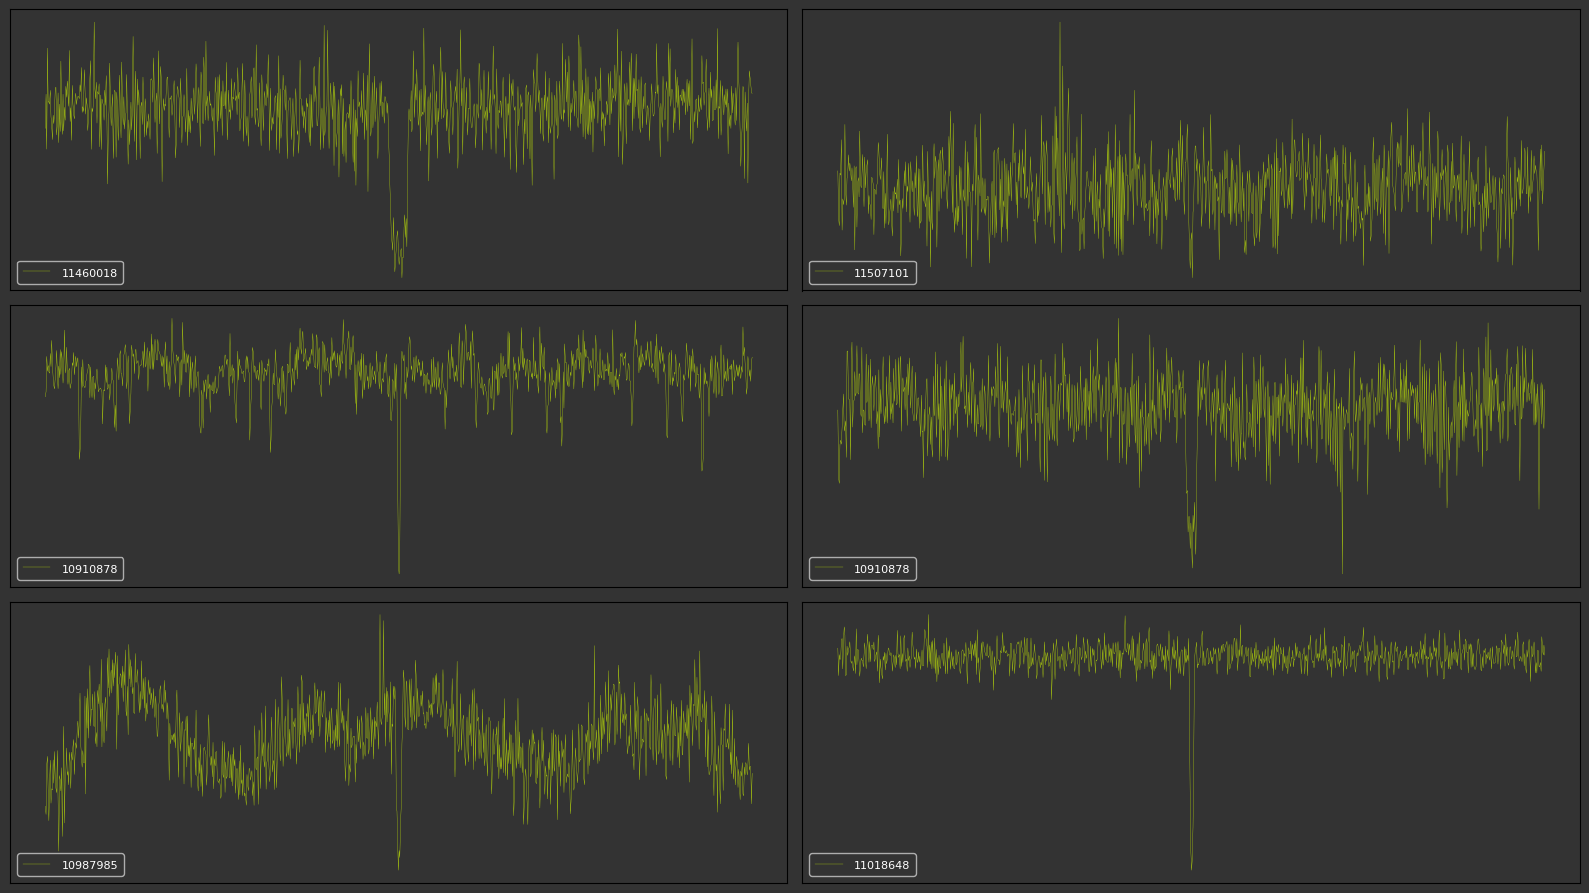

In [6]:
print(f'Exoplanet Light Curves')
condition_1 = df['label'] == 1.0
exmpl = df[condition_1]
plot_entries(exmpl[18:24])

Eclipsing Binary Light Curves


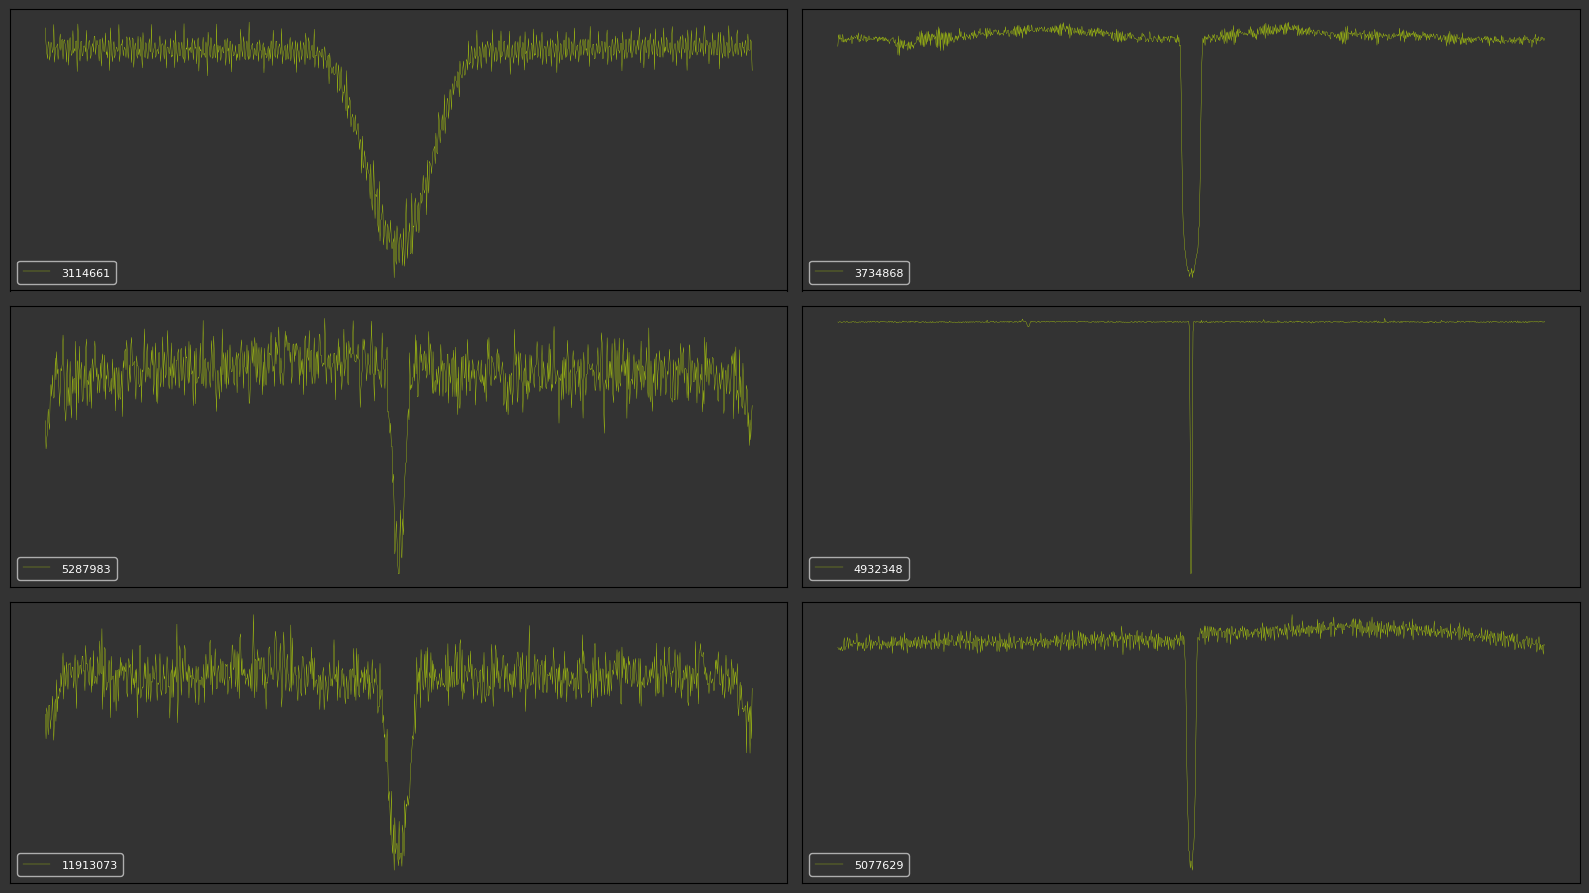

In [7]:
print(f'Eclipsing Binary Light Curves')
condition_2 = df['label'] == 0
exmpl_2 = df[condition_2]
plot_entries(exmpl_2[18:24])

In [8]:
df_fill = df.fillna(df.mean())

X = df_fill.drop(columns=['kepid', 'label'])
y = df_fill['label']

X

,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,flux_9,flux_10,...,flux_991,flux_992,flux_993,flux_994,flux_995,flux_996,flux_997,flux_998,flux_999,flux_1000
0,0.999956,0.999976,0.999927,0.999900,0.999946,0.999974,0.999817,1.000073,0.999805,0.999819,...,0.999979,0.999985,1.000216,0.999849,0.999988,0.999935,0.999952,1.000010,1.000180,0.999846
1,1.000090,0.995211,0.999933,1.000010,1.000484,1.000211,0.999942,1.000306,1.000175,1.000069,...,1.000286,1.000171,1.000071,1.000015,1.000282,1.000190,0.999994,1.000019,1.000038,1.000262
2,1.000086,1.000074,0.999959,1.000018,1.000172,0.999981,0.999912,1.000094,1.000037,1.000099,...,0.999837,1.000001,0.999999,0.999876,1.000060,0.999987,0.999778,0.999984,1.000067,0.999960
3,0.999984,1.000008,0.999981,0.999999,0.999918,0.999998,0.999958,0.999988,0.999988,0.999990,...,1.000001,1.000084,0.999993,1.000052,1.000010,0.999980,0.999998,1.000053,0.999989,0.999980
4,1.000903,1.001195,1.000961,1.000900,1.001421,1.001033,1.001075,1.000885,1.001231,1.000543,...,1.000900,1.000613,1.000885,1.000414,1.000970,1.000982,1.001035,1.000859,1.000877,1.001111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,0.971661,0.971380,0.972461,0.972846,0.972024,0.973323,0.972122,0.971978,0.974114,0.973077,...,0.973625,0.972629,0.972105,0.973354,0.971585,0.971950,0.972582,0.971816,0.972936,0.971686
4196,1.000045,1.000115,1.000045,1.000020,1.000069,0.999995,1.000116,1.000040,0.999952,0.999874,...,1.000017,1.000082,1.000066,0.999964,1.000027,1.000101,1.000195,1.000072,1.000057,1.000073
4197,1.001005,1.001022,1.001116,1.001035,1.000948,1.000980,1.001039,1.001080,1.001096,1.001126,...,1.000976,1.001043,1.000983,1.000996,1.001108,1.001121,1.000972,1.001069,1.001014,1.001113
4198,1.000072,1.000068,0.999932,0.999975,0.999950,1.000129,1.000051,1.000030,0.999845,1.000053,...,1.000047,1.000119,0.999851,1.000077,0.999927,0.999877,0.999769,1.000090,0.999959,1.000173


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=34
)


print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')

X_train.shape: (3360, 1000)
X_test.shape: (840, 1000)


In [10]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Model: MLP Deep Learning Model
Architecture
- 1 Dense input layer with units equal to number of features
- 2 Dense hidden layers
- 1 Dense output layer with 1 neuron for binary classification
- Dropout between layers to prevent overfitting
- Activation function: ReLU for hidden layers, sigmoid for output layer
- Optimizer: Adam
- Regularization: L2
- Learning rate: 0.01
- Early stopping

In [11]:
def create_model(X_train, activation='relu', learn_rate=0.01):
  model = models.Sequential()
  model.add(layers.Dense(units=X_train.shape[1],
                         input_dim=X_train.shape[1],
                         activation=activation,
                         kernel_regularizer='l2'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(units=128, activation=activation, kernel_regularizer='l2'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(units=64, activation=activation, kernel_regularizer='l2'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(units=1, activation='sigmoid'))

  optimizer = optimizers.Adam(learning_rate=learn_rate)

  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  return model

### Training and Prediction

In [12]:
EPOCHS = 50
VAL_SPLIT = 0.2
BATCH_SIZE = 75
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [13]:
model = create_model(X_train_scaled)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               128128    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [14]:
# Training
history = model.fit(X_train_scaled, y_train, validation_split=VAL_SPLIT, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=[early_stop])

Epoch 1/50
36/36 [==============================] - 16s 17ms/step - loss: 3.8345 - accuracy: 0.6410 - val_loss: 1.2423 - val_accuracy: 0.7262
Epoch 2/50
36/36 [==============================] - 0s 6ms/step - loss: 0.9221 - accuracy: 0.6804 - val_loss: 0.7847 - val_accuracy: 0.7277
Epoch 3/50
36/36 [==============================] - 0s 5ms/step - loss: 0.7855 - accuracy: 0.6964 - val_loss: 0.7705 - val_accuracy: 0.7634
Epoch 4/50
36/36 [==============================] - 0s 6ms/step - loss: 0.8486 - accuracy: 0.6570 - val_loss: 0.9961 - val_accuracy: 0.6607
Epoch 5/50
36/36 [==============================] - 0s 6ms/step - loss: 0.7805 - accuracy: 0.6782 - val_loss: 0.8051 - val_accuracy: 0.7143
Epoch 6/50
36/36 [==============================] - 0s 5ms/step - loss: 0.8994 - accuracy: 0.6443 - val_loss: 0.8315 - val_accuracy: 0.6964
Epoch 7/50
36/36 [==============================] - 0s 5ms/step - loss: 0.7253 - accuracy: 0.6905 - val_loss: 0.7444 - val_accuracy: 0.6964
Epoch 8/50
36/36 [

In [15]:
# Predictions
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

27/27 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.7238
Test Accuracy: 72.38%


### Model Performance & Observations


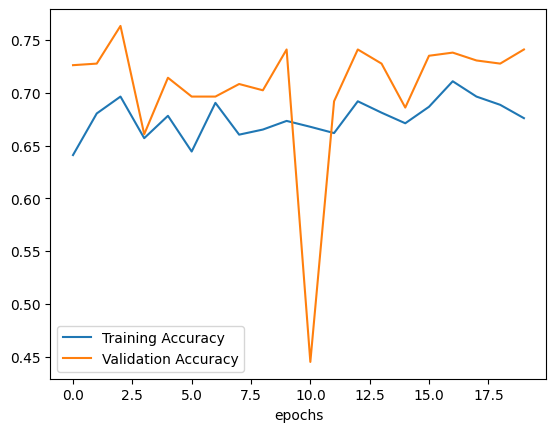

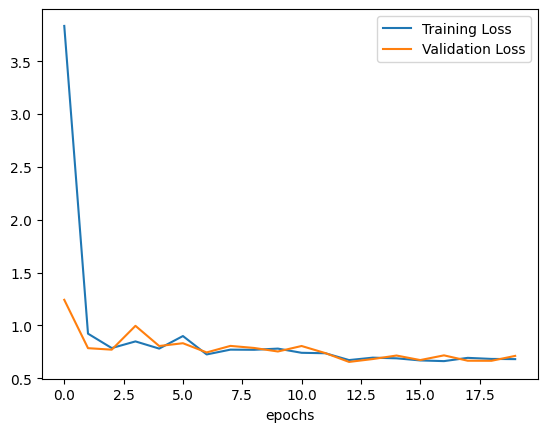

<Figure size 640x480 with 0 Axes>

In [25]:
def plot_history(history):
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('epochs')

  plt.legend()
  plt.figure()

  plt.plot(history.history['loss'], label = 'Training Loss')
  plt.plot(history.history['val_loss'], label = 'Validation Loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.figure()

  plt.show



plot_history(history)

### Model Performance Observations

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

y_pred = np.round(model.predict(np.array(X_test_scaled)))

print(accuracy_score(y_test, y_pred))

27/27 [==============================] - 0s 2ms/step
0.7238095238095238


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.43      0.60       405
         1.0       0.65      0.99      0.79       435

    accuracy                           0.72       840
   macro avg       0.82      0.71      0.70       840
weighted avg       0.81      0.72      0.70       840

Confusion Matrix


<Axes: xlabel='Predicted', ylabel='Actual'>

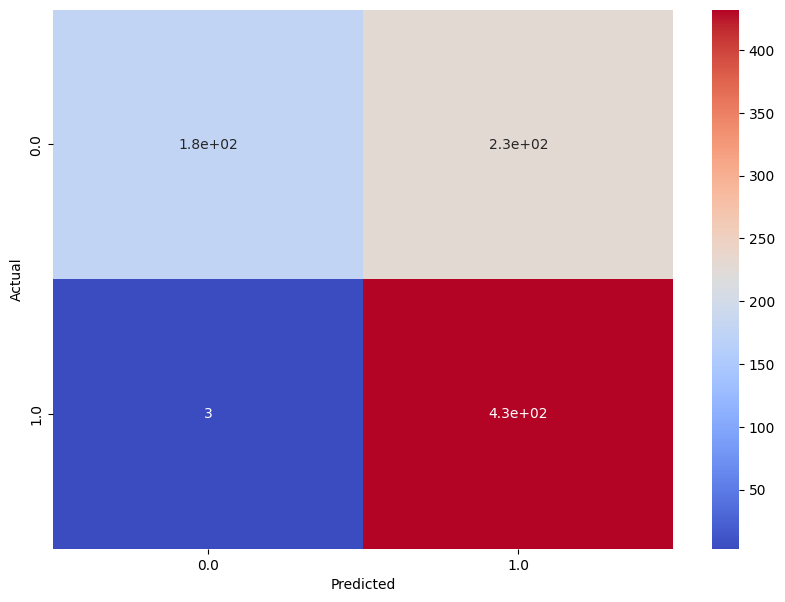

In [30]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix')
matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, cmap='coolwarm', annot=True)

Having

### Observations: Plotting misclassified entries

In [32]:
y_pred_int = np.argmax(y_pred, axis=1)

misclassified = np.where(y_pred_int != y_test)[0]
misclassified_df = pd.DataFrame(columns=df.columns)

for idx in misclassified:
  target = df.iloc[idx]
  misclassified_df.loc[len(misclassified_df)] = target

misclassified_0 = misclassified_df[misclassified_df['label'] == 0]
misclassified_1 = misclassified_df[misclassified_df['label'] == 1]

Misclassified Exoplanets


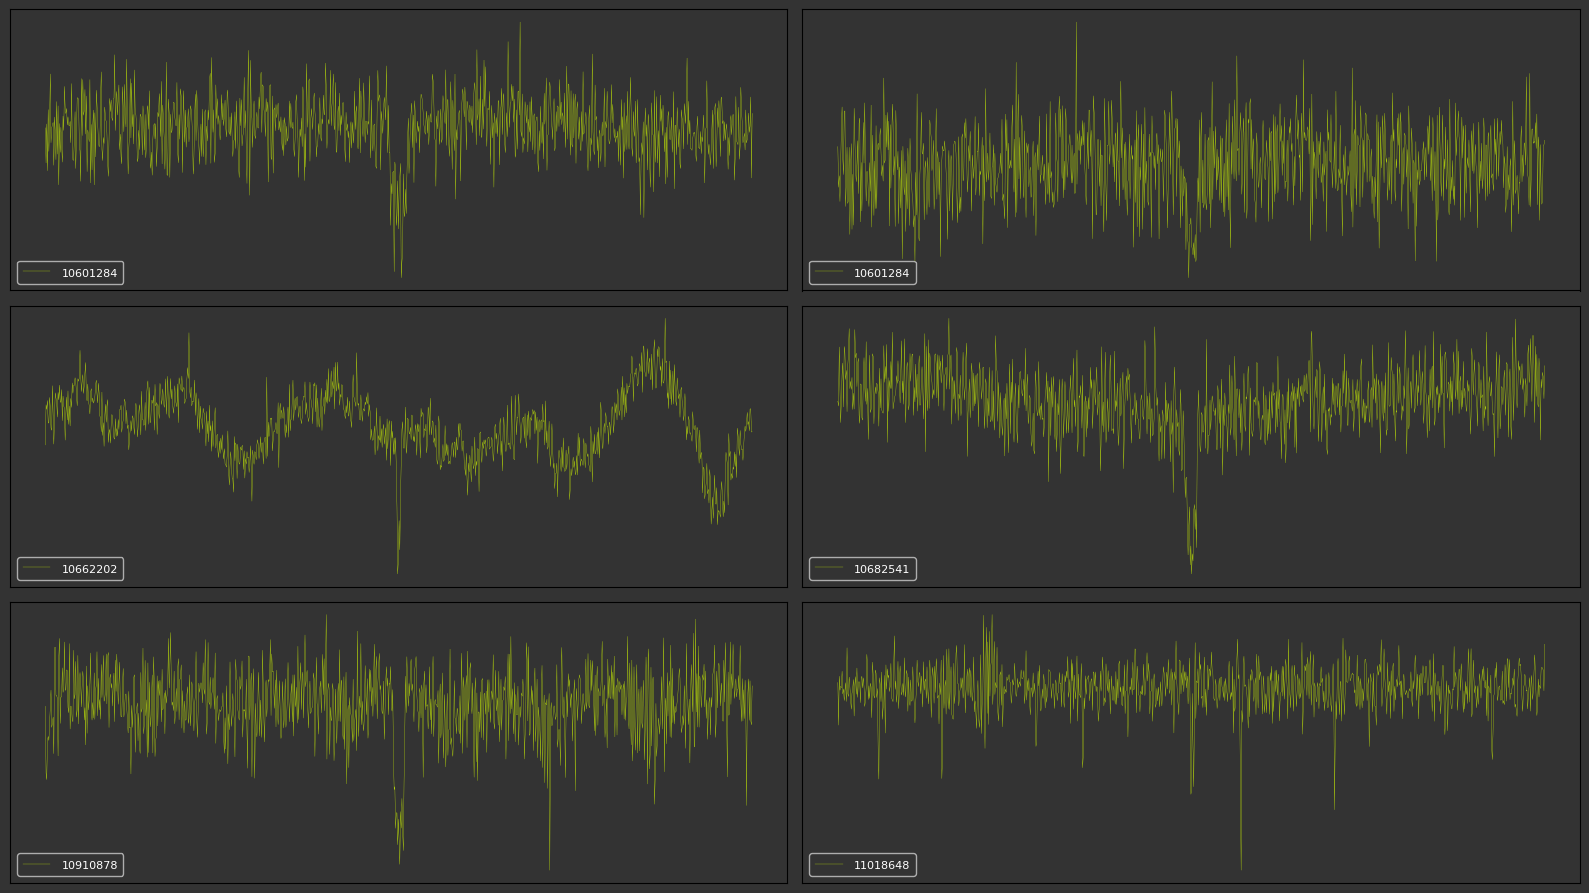

In [33]:
print("Misclassified Exoplanets")
plot_entries(misclassified_1[6:12])

Misclassified Eclipsing Binaries


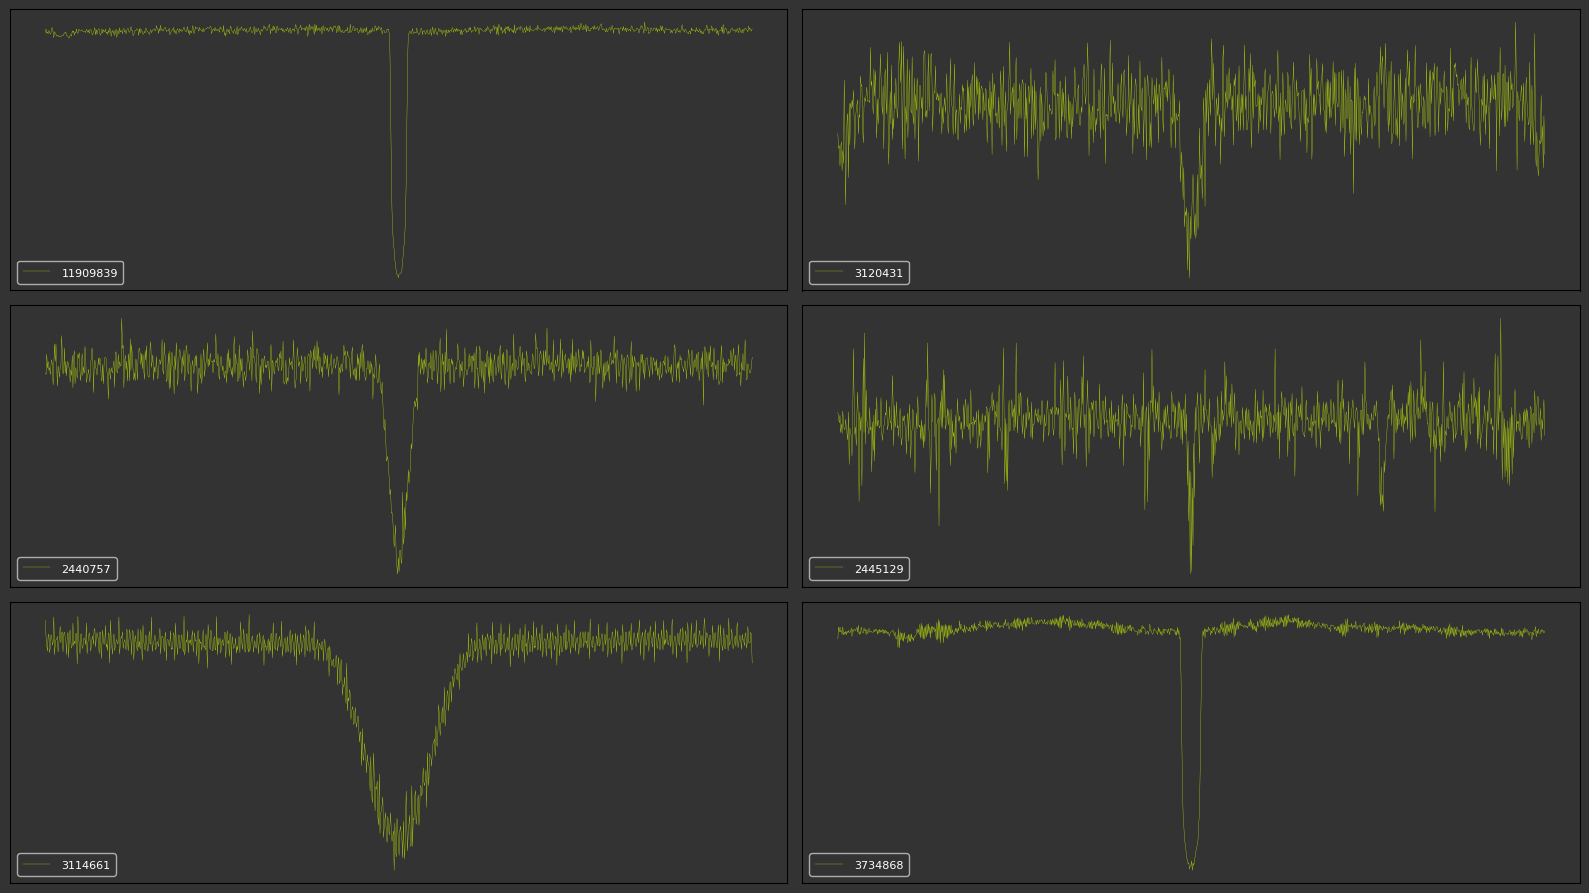

In [34]:
print("Misclassified Eclipsing Binaries")
plot_entries(misclassified_0[6:12])